In [1]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

import numpy as np

From GoDataDriven Advanced Data Science with Python course

# Feature Engineering: An example with bikes

The success of a machine learning algorithm is partly dependent on how you choose to represent the data.  You may have seen this before in practice with **preprocessing techniques** like *one hot encoding your categorical data*, data cleaning (removing or imputing *missing data*), and the effectivness of *scaling/normalizing* your data. 

Feature engineering is the **practice of creating new features** from your **existing** data or **additional** data sources to improve model performance. 

This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 from the [Capital bikeshare](https://www.capitalbikeshare.com/) system in Washington D.C..

Our target variable is `cnt` - the number of bikes rented out on a particular day. It also includes the corresponding weather and seasonal information: 

- `weathersit` : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- `temp` : Normalized temperature in Celsius. The values are divided to 41 (max)
- `atemp`: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- `hum`: Normalized humidity. The values are divided to 100 (max)
- `windspeed`: Normalized wind speed. The values are divided to 67 (max)

In [2]:
bikes = pd.read_csv('data/bike_rental_dataset.csv', parse_dates = ['datetime'], index_col='datetime')
bikes.head()

,weathersit,temp,atemp,hum,windspeed,cnt
datetime,,,,,,
2011-01-01 00:00:00,1,0.24,0.2879,0.81,0.0,16
2011-01-01 01:00:00,1,0.22,0.2727,0.80,0.0,40
2011-01-01 02:00:00,1,0.22,0.2727,0.80,0.0,32
2011-01-01 03:00:00,1,0.24,0.2879,0.75,0.0,13
2011-01-01 04:00:00,1,0.24,0.2879,0.75,0.0,1


<AxesSubplot:xlabel='datetime'>

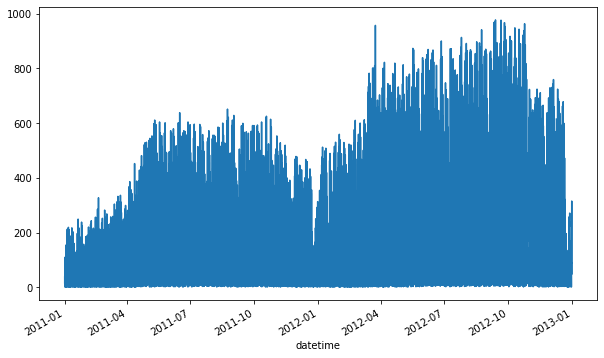

In [3]:
bikes['cnt'].plot(figsize=(10,6))

### <mark>Exercise: Let's get to know this data!</mark>

Answer the questions below.

Here are some methods that might be useful (remember to replace `df` with `bike`!):

1. `df.info()`, `df.isnull()`
2. `df.describe()`, `df.mean()`
3. `df.groupby(df.index.year).mean()`
4. `df['column'].plot()`


1. <mark>How many missing values are there in the data?</mark>

In [4]:
print(f"Empty values: {bikes.isna().values.any()} (count: {bikes.isnull().sum().sum()})")

Empty values: False (count: 0)


2. <mark>What is the earliest and latest date (min/max) in the data?</mark>

In [5]:
print(f"Dates from {bikes.index.min()} to {bikes.index.max()}.")

Dates from 2011-01-01 00:00:00 to 2012-12-31 23:00:00.


3. <mark>Which year was the most humid on average (mean)?</mark>

In [6]:
bikes = bikes.assign(
    year=bikes.index.year,
    month=bikes.index.month
)

bikes.groupby("year")["hum"].mean()

year
2011    0.643430
2012    0.611193
Name: hum, dtype: float64

4. <mark>Plot the amount of bikes (`cnt`) (Extra: by month) - how does the amount of bikes being rented change between 2011 and 2012?</mark>

<AxesSubplot:title={'center':'Number of bikes being rented per month'}, xlabel='month'>

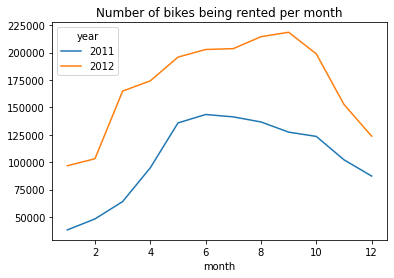

In [7]:
bikes.groupby(["month","year"])["cnt"].sum().unstack().plot(title="Number of bikes being rented per month")

---

In [8]:
def get_date_values(df):
    """ Preprocessing function
    Creates year, month, day, hour columns.
    """
    df = df.assign(**{'year': df.index.year,
                      'month': df.index.month,
                      'day': df.index.day,
                      'hour': df.index.hour})
    
    return df

bikes_processed = bikes.pipe(get_date_values)
bikes_processed.tail()

,weathersit,temp,atemp,hum,windspeed,cnt,year,month,day,hour
datetime,,,,,,,,,,
2012-12-31 19:00:00,2,0.26,0.2576,0.60,0.1642,119,2012,12,31,19
2012-12-31 20:00:00,2,0.26,0.2576,0.60,0.1642,89,2012,12,31,20
2012-12-31 21:00:00,1,0.26,0.2576,0.60,0.1642,90,2012,12,31,21
2012-12-31 22:00:00,1,0.26,0.2727,0.56,0.1343,61,2012,12,31,22
2012-12-31 23:00:00,1,0.26,0.2727,0.65,0.1343,49,2012,12,31,23


***Scikit Learn Steps***

1. Split data into X and y (features & target)
2. Encode the features in X where necessary (eg. create dummies)
3. Create train test split (without shuffling so the holdout is always the tail end of the data)
4. Build the model using a pipeline and specified model algorithm
5. Evaluate the model using Scikit Learn metrics (in our case r2)

<mark>**Question**: Why would we want the holdout test set to always be the tail end of the data in this scenario?</mark>
-> Since this dataset concers time series data, we wouldn't want to train our model on the future compared to the testing set.

In [9]:
def get_Xy(df, target_feature='cnt', onehotencoding = None):
    
    # create dummy features
    
    if onehotencoding:
        df = (
            df
            .join([pd.get_dummies(df[col]) for col in onehotencoding])
            .drop(onehotencoding, axis=1)
            .rename(str.lower, axis=1)
        )
    
    # split the independent features and the target into X and y
    
    X = df.drop([target_feature], axis=1)
    y = df.loc[:, target_feature]
    
    return X, y

def train_model(X, y, model, onehotcolumns=None, target_feature='cnt'):     
    """ Trains model
    
    X: pandas DataFrame of the features
    y: pandas Series of the target variable
    train_index: list of indices of X/y which belong to the train set
    test_index: list of indices of X/y which belong to the test set
    model: sklearn model
    """
    
    # create train-test set split. 
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
        
    # train the model. 
    pipeline = Pipeline(steps = [
        ('imputer', SimpleImputer()),
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    
    # evaluate the model. 
    y_train_pred = pipeline.predict(X_train)
    y_pred = pipeline.predict(X_test)
    score_train = r2_score(y_train, y_train_pred)
    score = r2_score(y_test, y_pred)
    print(f'Building model: {model}'.split('(')[0])
    print(f'Train score: {score_train.round(2)}')
    print(f'Test score: {score.round(2)}\n')
    
    return pipeline

In [10]:
forest_model = RandomForestRegressor(max_depth=6, random_state=1)
linear_model = LinearRegression()

In [11]:
# split X and y
X, y = bikes_processed.pipe(get_Xy)

# train models
lm = train_model(X, y, linear_model)
rf = train_model(X, y, forest_model)

Building model: LinearRegression
Train score: 0.39
Test score: 0.3

Building model: RandomForestRegressor
Train score: 0.71
Test score: 0.64



<a id='date'></a>

### Engineered features: date features
Feature engineering is the practice of adding features to your data based on what you think might provide additonal information. Let's think about this problem: our dataset concerns bike rentals. One might imagine the number of bikes rented may be correlated to the days people work, i.e. people will rent a bike to commute to work. Thinking about the dates, there are a couple of features of interest that we might want to add to our dataset:

* What is the day of the week (Monday, Tuesday, etc.)?
* What season is it?

In [12]:
def get_weekday(df):
    """Get the day of the week"""
    
    return df.assign(**{'weekday': df.index.day_name()})


def get_season(df):
    """Return the season based off:
    Dec, Jan, Feb = winter
    Mar, Apr, May = spring
    Jun, Jul, Aug = summer
    Sep, Oct, Nov = autumn"""
    
    season_mapping = {4: 'winter',
                      1: 'spring',
                      2: 'summer',
                      3: 'autumn'}
    
    # map the dates quarter to what season it is
    offset_months = df.index - pd.DateOffset(months=1)
    seasons = offset_months.quarter.map(season_mapping)
    
    return df.assign(season = seasons)

### <mark>Exercise: Feature generation</mark>

**Create two functions that add features to your data**. 

1. Create a boolean column called `is_weekday` where True is a weekday (Mon-Fri) and False a weekend day (Sat-Sun)

In [13]:
WEEKDAYS = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

def check_is_weekday(df):
    """Return a new column is_weekday
    Input: dataframe (df) with date column (default datetime)
    True when the date is a weekday (Mon-Fri)
    False when the date is a weekend day (Sat-Sun)"""
    
    return df.assign(is_weekday = df.weekday.isin(WEEKDAYS))

In [14]:
(
    bikes_processed
        .pipe(get_weekday)
        .pipe(get_season)
        .pipe(check_is_weekday)
)

,weathersit,temp,atemp,hum,windspeed,cnt,year,month,day,hour,weekday,season,is_weekday
datetime,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0.24,0.2879,0.81,0.0000,16,2011,1,1,0,Saturday,winter,False
2011-01-01 01:00:00,1,0.22,0.2727,0.80,0.0000,40,2011,1,1,1,Saturday,winter,False
2011-01-01 02:00:00,1,0.22,0.2727,0.80,0.0000,32,2011,1,1,2,Saturday,winter,False
2011-01-01 03:00:00,1,0.24,0.2879,0.75,0.0000,13,2011,1,1,3,Saturday,winter,False
2011-01-01 04:00:00,1,0.24,0.2879,0.75,0.0000,1,2011,1,1,4,Saturday,winter,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,2,0.26,0.2576,0.60,0.1642,119,2012,12,31,19,Monday,winter,True
2012-12-31 20:00:00,2,0.26,0.2576,0.60,0.1642,89,2012,12,31,20,Monday,winter,True
2012-12-31 21:00:00,1,0.26,0.2576,0.60,0.1642,90,2012,12,31,21,Monday,winter,True


<mark>**Questions:**
- <mark>How many weekend days are there in total? </mark>

In [15]:
bikes_date_features = (
    bikes_processed
        .pipe(get_weekday)
        .pipe(get_season)
        .pipe(check_is_weekday)
)

no_weekenddays = len(bikes_date_features[~bikes_date_features["is_weekday"]])/24

print(f"There are {no_weekenddays} weekend days in total.")

There are 208.91666666666666 weekend days in total.


Retrain the model on our new data:

In [16]:
# split X and y
X, y = get_Xy(bikes_date_features, onehotencoding = ['weekday', 'season'])

# train models
lm = train_model(X, y, linear_model)
rf = train_model(X, y, forest_model)

Building model: LinearRegression
Train score: 0.39
Test score: 0.3

Building model: RandomForestRegressor
Train score: 0.72
Test score: 0.65



<a id='past'></a>

### Engineered features: past behaviour
Another assumption we can make - and try out - is that behaviour in the past at similar time points might be predictive of behaviour of future behaviour. This leads us to a couple of other features to add: 
* How many bikes were rented in the past 12 hours? 
* How many bikes were rented in the past 12 days at the exact same hour (e.g. 3pm)? 
* How many bikes were rented at the same day (e.g. Tuesdays) and same hour (e.g. 9am) in the past 12 weeks? 


In [17]:
def remove_first(df, col_nam, timedelta):
    """ Return a cleaned version of column col_nam
    Input: dataframe (df) with a column (col_nam) and time window (timedelta)
    Keep the original column value if sufficient period of time has elapsed (timedelta)
    Otherwise return NaN """
    return (df
            .assign(**{col_nam: 
                       lambda df: np.where(df.index >= (df.index.min() + pd.Timedelta(timedelta)),
                                           df[col_nam], 
                                           np.nan)
                      })
           )


def get_mean_of_previous(df, col_nam, timedelta, grouper=None, 
                         prev_col='cnt', agg='mean'):
    """
    Return a new column col_name with the mean count of a previous time period
    
    Input: dataframe (df) with a column (col_nam), 
    window for rolling averages (timedelta), period of time to groupby (grouper),
    column to aggregate on (default 'cnt') and aggregation function (default 'mean').
    """
    
    # whether to groupby a particular time period
    if grouper is None:
        grouper = 'NoGroup'
        level_to_drop = 0
    else:
        level_to_drop = list(range(len(grouper)))
    
    return (
        df
        .assign(**{col_nam: (lambda df: df
                                   .sort_index()
                                    #allow for not grouping by time
                                   .assign(NoGroup=1)
                                    #groupby specified period of time
                                   .groupby(grouper)
                                    #rolling average using only past data
                                   .rolling(timedelta, closed='left')
                                    #aggregate on the column
                                   [prev_col].agg(agg)
                                    #remove multilevel indexing
                                   .droplevel(level_to_drop)
                                  )})
        .pipe(remove_first, col_nam, timedelta)
    )

bikes_inferred = (
    bikes_date_features
    .pipe(get_mean_of_previous, col_nam='last_12_hours', timedelta='12H')
    .pipe(get_mean_of_previous, col_nam='last_12_days', timedelta='12D', grouper=['hour'])
    .pipe(get_mean_of_previous, col_nam='last_12_weeks', timedelta=f'{12*7}D', grouper=['hour', 'weekday'])
)

### <mark>Exericse: Rebuild the model</mark>
Use the functions: `get_Xy` and `train_model` to get model performance metrics on the data with past behaviour metrics. 

**Note:** Scikit Learn will not allow `season` or `weekday`. Pass these in as the parameter `onehotencoding=` in the function `get_Xy()`.


In [18]:
# get X and y
X, y = get_Xy(bikes_inferred, onehotencoding = ['weekday', 'season'])

# train models
lm = train_model(X, y, linear_model)
rf = train_model(X, y, forest_model)

Building model: LinearRegression
Train score: 0.82
Test score: 0.8

Building model: RandomForestRegressor
Train score: 0.89
Test score: 0.81



Linear regression model seems to have greatly improved. Our Linear Regression model seemed to benefit little from our extra date features but thrives with our past behaviour based features. 

<mark>**Question:** Why would a linear regression model struggle to learn from (cyclical) datetime features?</mark> -> For example with the months: model sees month 1 and 12 as very far apart, however, these have the same distance as 11 and 12. 